# SuperResolution Prediction Using UNET

In [1]:
# Author Bereket Kebede, Graduate Student
# Neural Networks -  Final Project - University of Memphis. Fall 2021
# U-NET for Super-Resolution of Microscopy Images
# Last updated - Dec 04, 2021

In [29]:
#####################################################################################
# Import necessary libraries

import os
import torch
from torch.utils.data import  DataLoader
from skimage import io
import numpy as np
import sys
from unet_model import UNet
import warnings
import matplotlib.pyplot as plt
import imageio

In [30]:
#####################################################################################
# Check GPU and set environment

print("Torch cuda is available: ", torch.cuda.is_available())

# Add UNET phyton dependent files to envirnoment
path = 'C:/Users/CIRL/Desktop/Bereket/Neural Networks/Final Project UNET'
sys.path.append(path)
# never print matching warnings
warnings.filterwarnings('ignore')

Torch cuda is available:  True


In [31]:
#####################################################################################
# Data processing

class ToTensor(object):
    """"
    Convert ndarrays in sample to Tensors.
    
    """
    def __call__(self, sample):
        data_in = sample['image_in']
        name = sample['image_name']
        return {'image_in': torch.from_numpy(data_in),'image_name':name}

# Reconstruction
class ReconsDataset(torch.utils.data.Dataset):
    
     def __init__(self, test_in_path, transform, img_type,in_size):
        self.test_in_path = test_in_path
        self.transform = transform
        self.img_type = img_type
        self.in_size = in_size
        self.dirs_in = os.listdir(self.test_in_path)
     def __len__(self):
        dirs = os.listdir(self.test_in_path)   # open the files
        return len(dirs)            # because one of the file is for groundtruth

     def __getitem__(self, idx): 
         train_in_size = 3
         data_in = np.zeros((self.in_size, self.in_size, train_in_size))
         filepath = os.path.join(self.test_in_path, self.dirs_in[idx])
         for i in range(train_in_size):
             ii=i*5
             if ii <= 9:
                 image_name = os.path.join(filepath, "HE_0"+str(ii)+"." + self.img_type)
             else:
                image_name = os.path.join(filepath, "HE_"+str(ii)+"." + self.img_type)
             image = io.imread(image_name)
             # SCALING IMAGE if input isn't 256x256
             # image = rescale(image, 0.2, anti_aliasing=False)
             data_in[:,:,i] = image
         max_in = 5315.0
         data_in = data_in/max_in
         sample = {'image_in': data_in,'image_name':self.dirs_in[idx]}
         
         if self.transform:
             sample = self.transform(sample)
        
         return sample

def get_learning_rate(epoch):
    limits = [3, 8, 12]
    lrs = [1, 0.1, 0.05, 0.005]
    assert len(lrs) == len(limits) + 1
    for lim, lr in zip(limits, lrs):
        if epoch < lim:
            return lr * learning_rate
        return lrs[-1] * learning_rate
    
print("Data processing defined")

Data processing defined


In [32]:
#####################################################################################
# Forward propagation for prediction

if __name__ == "__main__":
    cuda = torch.device('cuda:0')
    learning_rate = 0.001
    # momentum = 0.99
    # weight_decay = 0.0001
    batch_size = 1

    # Microtuble test directory
    test_in_path = 'C:/Users/CIRL/Desktop/Bereket/Neural Networks/Final Project UNET/Data/microtubule/test/input'

    SRRFDATASET = ReconsDataset(test_in_path=test_in_path,
                                transform = ToTensor(),
                                img_type = 'tif',
                                in_size = 256)
    
    test_dataloader = torch.utils.data.DataLoader(SRRFDATASET, batch_size=batch_size, shuffle=True, pin_memory=True) # better than for loop

    model = UNet(n_channels=3, n_classes=1)
    
    print("{} paramerters in total".format(sum(x.numel() for x in model.parameters())))
    
    model.cuda(cuda)
    model.load_state_dict(torch.load("C:/Users/CIRL/Desktop/Bereket/Neural Networks/Final Project UNET/UNet_SIM3_microtubule.pkl"))
    model.eval()
    
    for batch_idx, items in enumerate(test_dataloader):
        
        image = items['image_in']
        image_name = items['image_name']
        print(image_name[0])
        model.train()
        
        image = np.swapaxes(image, 1,3)
        image = np.swapaxes(image, 2,3)
        image = image.float()
        image = image.cuda(cuda)
        
        pred = model(image)
        max_out = 15383.0
        pred = pred*max_out
       
        io.imsave('C:/Users/CIRL/Desktop/Bereket/Neural Networks/Final Project UNET/Data/microtubule/test/prediction/' + image_name[0] + '_pred.tif',pred.detach().cpu().numpy().astype(np.uint32))


31043521 paramerters in total
Sample_2
Sample_1


In [43]:
#####################################################################################
# Load data for Preview

WF = plt.imread('C:/Users/CIRL/Desktop/Bereket/Neural Networks/Final Project UNET/Data/microtubule/test/input/Sample_1/HE_00.tif')
SR = imageio.imread('C:/Users/CIRL/Desktop/Bereket/Neural Networks/Final Project UNET/Data/microtubule/test/prediction/Sample_1_pred.tif')

Text(0.5, 1.0, 'Super-Resolution by U-NET')

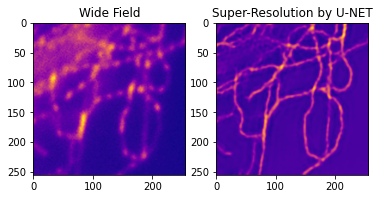

In [44]:
#####################################################################################
# Visualize predicted data
# If image isn't displayable in phyton,jupyter. Use ImageJ to display the output

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(WF, cmap='plasma')
plt.title('Wide Field')
f.add_subplot(1,2,2)
plt.imshow(SR, cmap='plasma')
plt.title('Super-Resolution by U-NET')